In [1]:
import os
if not os.path.exists('Faceswap-Deepfake-Pytorch'):
  !wget -q https://www.dropbox.com/s/5ji7jl7httso9ny/person_images.zip
  !wget -q https://raw.githubusercontent.com/sizhky/deep-fake-util/main/random_warp.py
  !unzip -q person_images.zip
!pip install -q torch_snippets torch_summary
from torch_snippets import *
from random_warp import get_training_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 1.7 MB/s eta 0:00

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import cv2
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [4]:
def crop_face(img):
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,1.3,5)
  if(len(faces)>0):
    for (x,y,w,h) in faces:
      img2 = img[y:(y+h),x:(x+w),:]
    img2 = cv2.resize(img2,(256,256))

    return img2,True
  else:
    return img,False

In [5]:
!mkdir cropped_faces_personA
!mkdir cropped_faces_personB

In [6]:
def crop_images(folder):
  images = Glob(folder+'/*.jpg')
  for i in range(len(images)):
    img = read(images[i],1)
    img2, face_detected = crop_face(img)
    if(face_detected==False):
      continue
    else:
      cv2.imwrite('cropped_faces_'+folder+'/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
crop_images('personA')
crop_images('personB')

In [7]:
from torch.utils.data import Dataset,DataLoader

class face_dataset(Dataset):
  def __init__(self,items_a,items_b):
    self.items_A = np.concatenate([read(f,1)[None] for f in items_a])/255.
    self.items_B = np.concatenate([read(f,1)[None] for f in items_b])/255.

    self.items_A += self.items_B.mean(axis=(0,1,2)) - self.items_A.mean(axis=(0,1,2))

  def __len__(self):
    return min(len(self.items_A),len(self.items_B))
  def __getitem__(self,ix):
    a,b = choose(self.items_A),choose(self.items_B)
    return a,b
  def collate_fn(self,batch):
    imsA,imsB = list(zip(*batch))
    imsA ,targetA = get_training_data(imsA,len(imsB))
    imsB ,targetB = get_training_data(imsB,len(imsB))

    imsA,imsB,targetA,targetB = [torch.Tensor(i).permute(0,3,1,2).to(device) for i in [imsA,imsB,targetA,targetB]]

    return imsA,imsB,targetA,targetB

In [8]:
a = face_dataset(Glob('cropped_faces_personA'),Glob("cropped_faces_personB"))

In [9]:
data_dl = DataLoader(a,batch_size=32,collate_fn = a.collate_fn)

══════════════════════════════════════════════════════════════════

tensor([[[[0.6462, 0.6432, 0.6318,  ..., 0.4278, 0.4382, 0.4070],
          [0.6588, 0.6621, 0.6413,  ..., 0.4053, 0.4230, 0.4020],
          [0.6833, 0.6812, 0.6649,  ..., 0.3868, 0.4100, 0.3935],
          ...,
          [0.6128, 0.6274, 0.6488,  ..., 0.2364, 0.2247, 0.2019],
          [0.6002, 0.6141, 0.6355,  ..., 0.2308, 0.2182, 0.2002],
          [0.5913, 0.6073, 0.6274,  ..., 0.2202, 0.2140, 0.1959]],

         [[0.5263, 0.5234, 0.5120,  ..., 0.3355, 0.3531, 0.3339],
          [0.5348, 0.5367, 0.5215,  ..., 0.3132, 0.3428, 0.3292],
          [0.5517, 0.5497, 0.5391,  ..., 0.2973, 0.3327, 0.3208],
          ...,
          [0.4734, 0.4880, 0.5094,  ..., 0.1831, 0.1725, 0.1563],
          [0.4608, 0.4747, 0.4961,  ..., 0.1761, 0.1710, 0.1548],
          [0.4519, 0.4679, 0.4880,  ..., 0.1686, 0.1642, 0.1492]],

         [[0.4164, 0.4132, 0.4018,  ..., 0.2253, 0.2405, 0.2161],
          [0.4357, 0.4284, 0.4113,  ..., 0.2029, 0.2282, 0.2112],
          [0.4527, 0.4434, 0.4310,  ..., 0.1862, 0.2170, 0.2028],
          ...,
          [0.4164, 0.4248, 0.4411,  ..., 0.1395, 0.1286, 0.1090],
          [0.4055, 0.4121, 0.4276,  ..., 0.1344, 0.1259, 0.1077],
          [0.3966, 0.4049, 0.4242,  ..., 0.1291, 0.1247, 0.1045]]],


        [[[0.5499, 0.5104, 0.4712,  ..., 0.6902, 0.6779, 0.6741],
          [0.5322, 0.4978, 0.4640,  ..., 0.6819, 0.6755, 0.6683],
          [0.5238, 0.4901, 0.4594,  ..., 0.6647, 0.6540, 0.6435],
          ...,
          [0.6126, 0.5459, 0.4877,  ..., 0.6964, 0.6962, 0.6992],
          [0.5539, 0.5107, 0.4656,  ..., 0.7022, 0.6997, 0.6997],
          [0.4856, 0.4717, 0.4616,  ..., 0.7044, 0.7030, 0.6988]],

         [[0.4812, 0.4291, 0.3827,  ..., 0.5579, 0.5482, 0.5387],
          [0.4681, 0.4204, 0.3756,  ..., 0.5621, 0.5493, 0.5410],
          [0.4601, 0.4133, 0.3710,  ..., 0.5415, 0.5318, 0.5249],
          ...,
          [0.6271, 0.5510, 0.4780,  ..., 0.5610, 0.5608, 0.5582],
          [0.5671, 0.5057, 0.4540,  ..., 0.5667, 0.5636, 0.5564],
          [0.4976, 0.4664, 0.4341,  ..., 0.5690, 0.5675, 0.5571]],

         [[0.3440, 0.2875, 0.2426,  ..., 0.4777, 0.4636, 0.4560],
          [0.3285, 0.2777, 0.2347,  ..., 0.4839, 0.4739, 0.4664],
          [0.3210, 0.2696, 0.2319,  ..., 0.4809, 0.4707, 0.4565],
          ...,
          [0.6225, 0.5227, 0.4243,  ..., 0.4783, 0.4784, 0.4782],
          [0.5584, 0.4785, 0.3984,  ..., 0.4840, 0.4812, 0.4776],
          [0.4812, 0.4267, 0.3729,  ..., 0.4863, 0.4848, 0.4775]]],


        [[[0.4852, 0.4911, 0.5257,  ..., 0.4844, 0.4177, 0.3863],
          [0.4717, 0.4862, 0.5185,  ..., 0.5060, 0.4404, 0.3885],
          [0.4530, 0.4913, 0.5294,  ..., 0.5307, 0.4574, 0.3958],
          ...,
          [0.2323, 0.5001, 0.6246,  ..., 0.6479, 0.6242, 0.6053],
          [0.2281, 0.4503, 0.6107,  ..., 0.6432, 0.6216, 0.6075],
          [0.2146, 0.3945, 0.5950,  ..., 0.6392, 0.6155, 0.5985]],

         [[0.4010, 0.4004, 0.4259,  ..., 0.3714, 0.3167, 0.2828],
          [0.3793, 0.3938, 0.4187,  ..., 0.3931, 0.3291, 0.2808],
          [0.3607, 0.3989, 0.4297,  ..., 0.4172, 0.3454, 0.2839],
          ...,
          [0.1750, 0.4167, 0.5250,  ..., 0.4928, 0.4716, 0.4590],
          [0.1732, 0.3747, 0.5132,  ..., 0.4952, 0.4746, 0.4612],
          [0.1620, 0.3197, 0.4956,  ..., 0.4960, 0.4742, 0.4590]],

         [[0.2907, 0.2981, 0.3273,  ..., 0.2770, 0.2192, 0.1963],
          [0.2692, 0.2888, 0.3126,  ..., 0.2986, 0.2347, 0.1933],
          [0.2483, 0.2850, 0.3229,  ..., 0.3227, 0.2510, 0.1933],
          ...,
          [0.1238, 0.3609, 0.4609,  ..., 0.4288, 0.4149, 0.4084],
          [0.1219, 0.3141, 0.4496,  ..., 0.4281, 0.4163, 0.4094],
          [0.1102, 0.2646, 0.4384,  ..., 0.4254, 0.4121, 0.3960]]],


        ...,


        [[[0.3943, 0.3972, 0.3862,  ..., 0.6469, 0.6410, 0.6502],
          [0.3998, 0.4028, 0.3903,  ..., 0.6418, 0.6391, 0.6517],
          [0.4222, 0.4207, 0.4089,  ..., 0.6341, 0.6312, 0.6448],
          ...,
          [0.6265, 0.6340, 0.6413,  ..., 0.3778, 

══════════════════════════════════════════════════════════════════

tensor([[[[0.2200, 0.2141, 0.2113,  ..., 0.7115, 0.7246, 0.7293],
          [0.2242, 0.2327, 0.2361,  ..., 0.6512, 0.6629, 0.6704],
          [0.2300, 0.2303, 0.2472,  ..., 0.5609, 0.5865, 0.6326],
          ...,
          [0.3307, 0.3928, 0.4168,  ..., 0.7282, 0.7329, 0.7252],
          [0.3442, 0.4031, 0.4208,  ..., 0.7154, 0.7176, 0.7085],
          [0.3543, 0.4159, 0.4294,  ..., 0.7011, 0.6985, 0.6956]],

         [[0.2004, 0.1945, 0.1917,  ..., 0.6096, 0.6230, 0.6241],
          [0.2046, 0.2054, 0.2104,  ..., 0.5602, 0.5609, 0.5668],
          [0.2110, 0.2107, 0.2199,  ..., 0.4723, 0.4918, 0.5354],
          ...,
          [0.3268, 0.3893, 0.4193,  ..., 0.5882, 0.5996, 0.5948],
          [0.3403, 0.3991, 0.4175,  ..., 0.5796, 0.5882, 0.5824],
          [0.3504, 0.4120, 0.4261,  ..., 0.5737, 0.5730, 0.5764]],

         [[0.1769, 0.1710, 0.1682,  ..., 0.5430, 0.5530, 0.5526],
          [0.1811, 0.1819, 0.1869,  ..., 0.4972, 0.5001, 0.5001],
          [0.1950, 0.1872, 0.1944,  ..., 0.4157, 0.4302, 0.4703],
          ...,
          [0.3075, 0.3719, 0.3965,  ..., 0.4860, 0.4956, 0.4968],
          [0.3218, 0.3834, 0.4012,  ..., 0.4803, 0.4902, 0.4844],
          [0.3333, 0.3963, 0.4101,  ..., 0.4787, 0.4759, 0.4816]]],


        [[[0.3393, 0.4337, 0.4764,  ..., 0.8435, 0.8451, 0.8471],
          [0.3922, 0.4653, 0.4851,  ..., 0.8568, 0.8539, 0.8468],
          [0.4293, 0.4822, 0.4932,  ..., 0.8624, 0.8584, 0.8509],
          ...,
          [0.3385, 0.3609, 0.3983,  ..., 0.7083, 0.7004, 0.6992],
          [0.3565, 0.3488, 0.3841,  ..., 0.7151, 0.7090, 0.6907],
          [0.3754, 0.3404, 0.3748,  ..., 0.7060, 0.6985, 0.6802]],

         [[0.2931, 0.3687, 0.3919,  ..., 0.7063, 0.7079, 0.7098],
          [0.3394, 0.3928, 0.4017,  ..., 0.7196, 0.7166, 0.7095],
          [0.3695, 0.4051, 0.4095,  ..., 0.7252, 0.7212, 0.7136],
          ...,
          [0.3076, 0.3130, 0.3433,  ..., 0.5908, 0.5879, 0.5894],
          [0.3309, 0.3096, 0.3409,  ..., 0.5962, 0.5922, 0.5829],
          [0.3478, 0.3073, 0.3325,  ..., 0.5929, 0.5896, 0.5744]],

         [[0.2625, 0.3269, 0.3367,  ..., 0.6200, 0.6216, 0.6235],
          [0.3054, 0.3473, 0.3403,  ..., 0.6412, 0.6382, 0.6311],
          [0.3326, 0.3576, 0.3427,  ..., 0.6468, 0.6427, 0.6352],
          ...,
          [0.2743, 0.2706, 0.2890,  ..., 0.4978, 0.5025, 0.5032],
          [0.2973, 0.2699, 0.2908,  ..., 0.5059, 0.5089, 0.4988],
          [0.3089, 0.2633, 0.2825,  ..., 0.5039, 0.5060, 0.4920]]],


        [[[0.4186, 0.4154, 0.2945,  ..., 0.8040, 0.8151, 0.8044],
          [0.4040, 0.4339, 0.3323,  ..., 0.7263, 0.7478, 0.7615],
          [0.3997, 0.4461, 0.3201,  ..., 0.6159, 0.6535, 0.6942],
          ...,
          [0.4205, 0.4244, 0.4209,  ..., 0.6983, 0.7013, 0.6856],
          [0.4237, 0.4270, 0.4256,  ..., 0.6951, 0.6998, 0.6765],
          [0.4262, 0.4237, 0.4284,  ..., 0.6792, 0.6912, 0.6552]],

         [[0.3025, 0.3147, 0.2321,  ..., 0.6946, 0.7051, 0.6946],
          [0.2673, 0.3216, 0.2616,  ..., 0.6209, 0.6422, 0.6557],
          [0.2620, 0.3322, 0.2562,  ..., 0.5262, 0.5540, 0.5926],
          ...,
          [0.4244, 0.4196, 0.4037,  ..., 0.5662, 0.5830, 0.5771],
          [0.4267, 0.4231, 0.4161,  ..., 0.5679, 0.5823, 0.5758],
          [0.4280, 0.4198, 0.4216,  ..., 0.5595, 0.5817, 0.5645]],

         [[0.2772, 0.2739, 0.1859,  ..., 0.6132, 0.6227, 0.6124],
          [0.2313, 0.2766, 0.2212,  ..., 0.5474, 0.5685, 0.5814],
          [0.2244, 0.2892, 0.2185,  ..., 0.4588, 0.4882, 0.5260],
          ...,
          [0.4044, 0.4018, 0.3779,  ..., 0.4615, 0.4886, 0.4901],
          [0.4075, 0.4074, 0.3918,  ..., 0.4741, 0.4926, 0.4854],
          [0.4094, 0.4037, 0.3991,  ..., 0.4671, 0.4952, 0.4729]]],


        ...,


        [[[0.2903, 0.3522, 0.4050,  ..., 0.8035, 0.7949, 0.7846],
          [0.3097, 0.3577, 0.4046,  ..., 0.8030, 0.7898, 0.7904],
          [0.3131, 0.3552, 0.4006,  ..., 0.7948, 0.7807, 0.7740],
          ...,
          [0.4181, 0.3693, 0.3613,  ..., 0.7395, 

══════════════════════════════════════════════════════════════════

tensor([[[[0.6348, 0.6432, 0.6414,  ..., 0.4830, 0.4455, 0.4056],
          [0.6500, 0.6526, 0.6534,  ..., 0.4707, 0.4496, 0.4033],
          [0.6537, 0.6644, 0.6744,  ..., 0.4540, 0.4374, 0.4013],
          ...,
          [0.5876, 0.5975, 0.6166,  ..., 0.2227, 0.2048, 0.1875],
          [0.5803, 0.5853, 0.6089,  ..., 0.2290, 0.2060, 0.1857],
          [0.5697, 0.5784, 0.5987,  ..., 0.2191, 0.1997, 0.1827]],

         [[0.5163, 0.5230, 0.5216,  ..., 0.3906, 0.3531, 0.3134],
          [0.5265, 0.5290, 0.5336,  ..., 0.3783, 0.3603, 0.3223],
          [0.5298, 0.5380, 0.5429,  ..., 0.3613, 0.3569, 0.3207],
          ...,
          [0.4572, 0.4590, 0.4771,  ..., 0.1696, 0.1570, 0.1422],
          [0.4487, 0.4528, 0.4695,  ..., 0.1764, 0.1596, 0.1404],
          [0.4432, 0.4468, 0.4593,  ..., 0.1662, 0.1524, 0.1373]],

         [[0.4084, 0.4140, 0.4114,  ..., 0.2728, 0.2391, 0.1949],
          [0.4277, 0.4304, 0.4235,  ..., 0.2670, 0.2489, 0.2027],
          [0.4392, 0.4421, 0.4368,  ..., 0.2514, 0.2428, 0.2066],
          ...,
          [0.4035, 0.4038, 0.4189,  ..., 0.1261, 0.1108, 0.0948],
          [0.3974, 0.4010, 0.4139,  ..., 0.1327, 0.1128, 0.0930],
          [0.3945, 0.3957, 0.4040,  ..., 0.1266, 0.1091, 0.0899]]],


        [[[0.5150, 0.5603, 0.5641,  ..., 0.6916, 0.6900, 0.6768],
          [0.5146, 0.5544, 0.5502,  ..., 0.6947, 0.6821, 0.6737],
          [0.5117, 0.5502, 0.5408,  ..., 0.6794, 0.6741, 0.6640],
          ...,
          [0.6606, 0.6459, 0.5811,  ..., 0.6915, 0.6815, 0.6738],
          [0.6285, 0.6111, 0.5437,  ..., 0.6878, 0.6679, 0.6577],
          [0.5636, 0.5523, 0.5159,  ..., 0.6787, 0.6558, 0.6443]],

         [[0.5485, 0.5362, 0.5069,  ..., 0.5679, 0.5551, 0.5421],
          [0.5460, 0.5328, 0.4956,  ..., 0.5671, 0.5558, 0.5456],
          [0.5403, 0.5243, 0.4886,  ..., 0.5585, 0.5529, 0.5409],
          ...,
          [0.6801, 0.6581, 0.5856,  ..., 0.5482, 0.5382, 0.5306],
          [0.6455, 0.6242, 0.5483,  ..., 0.5445, 0.5258, 0.5183],
          [0.5808, 0.5662, 0.5115,  ..., 0.5363, 0.5164, 0.5049]],

         [[0.4579, 0.4326, 0.3866,  ..., 0.4811, 0.4727, 0.4591],
          [0.4494, 0.4219, 0.3672,  ..., 0.4922, 0.4787, 0.4638],
          [0.4394, 0.4081, 0.3516,  ..., 0.4893, 0.4824, 0.4684],
          ...,
          [0.6924, 0.6526, 0.5536,  ..., 0.4706, 0.4666, 0.4597],
          [0.6528, 0.6186, 0.5191,  ..., 0.4733, 0.4549, 0.4479],
          [0.5885, 0.5583, 0.4870,  ..., 0.4671, 0.4533, 0.4418]]],


        [[[0.5049, 0.5125, 0.5145,  ..., 0.5226, 0.4765, 0.4387],
          [0.5012, 0.5171, 0.5041,  ..., 0.5482, 0.4951, 0.4472],
          [0.5042, 0.5199, 0.4894,  ..., 0.5657, 0.5177, 0.4605],
          ...,
          [0.1995, 0.2176, 0.3331,  ..., 0.6153, 0.5952, 0.5807],
          [0.1994, 0.2082, 0.2678,  ..., 0.6169, 0.6006, 0.5824],
          [0.1926, 0.2099, 0.2403,  ..., 0.6078, 0.5945, 0.5795]],

         [[0.4243, 0.4319, 0.4338,  ..., 0.4099, 0.3645, 0.3385],
          [0.4206, 0.4331, 0.4199,  ..., 0.4339, 0.3830, 0.3424],
          [0.4159, 0.4276, 0.3971,  ..., 0.4498, 0.4028, 0.3501],
          ...,
          [0.1524, 0.1656, 0.2641,  ..., 0.4675, 0.4546, 0.4438],
          [0.1526, 0.1607, 0.2036,  ..., 0.4684, 0.4588, 0.4514],
          [0.1462, 0.1646, 0.1823,  ..., 0.4649, 0.4550, 0.4486]],

         [[0.3037, 0.3179, 0.3198,  ..., 0.3139, 0.2700, 0.2401],
          [0.3065, 0.3202, 0.3070,  ..., 0.3347, 0.2882, 0.2456],
          [0.3057, 0.3172, 0.2820,  ..., 0.3475, 0.3079, 0.2551],
          ...,
          [0.1059, 0.1141, 0.2090,  ..., 0.4157, 0.4007, 0.3942],
          [0.1060, 0.1089, 0.1488,  ..., 0.4142, 0.4073, 0.3997],
          [0.0994, 0.1172, 0.1311,  ..., 0.4045, 0.3994, 0.3969]]],


        ...,


        [[[0.3993, 0.3992, 0.3982,  ..., 0.6414, 0.6464, 0.6560],
          [0.4190, 0.4184, 0.4131,  ..., 0.6389, 0.6446, 0.6516],
          [0.4347, 0.4301, 0.4229,  ..., 0.6348, 0.6352, 0.6464],
          ...,
          [0.6315, 0.6405, 0.6485,  ..., 0.3747, 

══════════════════════════════════════════════════════════════════

tensor([[[[0.2252, 0.2055, 0.1900,  ..., 0.8174, 0.8164, 0.8209],
          [0.2281, 0.2176, 0.2187,  ..., 0.8094, 0.8047, 0.8071],
          [0.2311, 0.2303, 0.2438,  ..., 0.8093, 0.8038, 0.7992],
          ...,
          [0.3032, 0.3799, 0.4211,  ..., 0.7249, 0.7362, 0.7283],
          [0.3060, 0.3784, 0.4140,  ..., 0.7142, 0.7257, 0.7111],
          [0.3170, 0.3876, 0.4153,  ..., 0.6991, 0.7038, 0.6971]],

         [[0.2056, 0.1859, 0.1710,  ..., 0.6899, 0.6831, 0.6876],
          [0.2084, 0.1971, 0.1991,  ..., 0.6877, 0.6794, 0.6800],
          [0.2133, 0.2072, 0.2167,  ..., 0.6924, 0.6866, 0.6812],
          ...,
          [0.2993, 0.3760, 0.4172,  ..., 0.5820, 0.6028, 0.5957],
          [0.3020, 0.3745, 0.4177,  ..., 0.5740, 0.5923, 0.5850],
          [0.3131, 0.3836, 0.4139,  ..., 0.5670, 0.5767, 0.5751]],

         [[0.1821, 0.1624, 0.1472,  ..., 0.6001, 0.5850, 0.5896],
          [0.1849, 0.1736, 0.1756,  ..., 0.5989, 0.5836, 0.5820],
          [0.1946, 0.1842, 0.1930,  ..., 0.6079, 0.5928, 0.5870],
          ...,
          [0.2797, 0.3603, 0.3976,  ..., 0.4800, 0.4987, 0.4976],
          [0.2824, 0.3587, 0.3943,  ..., 0.4727, 0.4942, 0.4869],
          [0.2935, 0.3680, 0.3941,  ..., 0.4690, 0.4799, 0.4788]]],


        [[[0.3429, 0.4107, 0.4573,  ..., 0.8395, 0.8473, 0.8357],
          [0.3588, 0.4300, 0.4699,  ..., 0.8465, 0.8497, 0.8459],
          [0.3871, 0.4535, 0.4807,  ..., 0.8525, 0.8458, 0.8475],
          ...,
          [0.3668, 0.4141, 0.4327,  ..., 0.7004, 0.7077, 0.7119],
          [0.3475, 0.3892, 0.4184,  ..., 0.7144, 0.7098, 0.7119],
          [0.3377, 0.3639, 0.3995,  ..., 0.7069, 0.7041, 0.6996]],

         [[0.3023, 0.3447, 0.3762,  ..., 0.7022, 0.7061, 0.6946],
          [0.3127, 0.3630, 0.3844,  ..., 0.7085, 0.7085, 0.7047],
          [0.3327, 0.3819, 0.3961,  ..., 0.7138, 0.7046, 0.7063],
          ...,
          [0.3257, 0.3522, 0.3552,  ..., 0.5767, 0.5900, 0.5918],
          [0.3091, 0.3312, 0.3479,  ..., 0.5917, 0.5921, 0.5947],
          [0.3027, 0.3139, 0.3406,  ..., 0.5883, 0.5865, 0.5890]],

         [[0.2670, 0.3047, 0.3216,  ..., 0.6163, 0.6120, 0.6004],
          [0.2789, 0.3222, 0.3313,  ..., 0.6274, 0.6187, 0.6179],
          [0.2992, 0.3364, 0.3396,  ..., 0.6326, 0.6183, 0.6200],
          ...,
          [0.2805, 0.2984, 0.3012,  ..., 0.4795, 0.4958, 0.5068],
          [0.2650, 0.2805, 0.2927,  ..., 0.5001, 0.4980, 0.5094],
          [0.2676, 0.2684, 0.2883,  ..., 0.4947, 0.4923, 0.5020]]],


        [[[0.2380, 0.2308, 0.2491,  ..., 0.8399, 0.8328, 0.8266],
          [0.2559, 0.2188, 0.2492,  ..., 0.8306, 0.8286, 0.8262],
          [0.2652, 0.2089, 0.2383,  ..., 0.7745, 0.7671, 0.7716],
          ...,
          [0.4317, 0.4143, 0.3702,  ..., 0.7158, 0.7118, 0.6896],
          [0.4327, 0.4351, 0.4107,  ..., 0.6990, 0.6869, 0.6693],
          [0.4313, 0.4352, 0.4379,  ..., 0.6761, 0.6666, 0.6595]],

         [[0.1984, 0.1955, 0.2138,  ..., 0.7183, 0.7112, 0.7051],
          [0.2039, 0.1805, 0.2136,  ..., 0.7201, 0.7141, 0.7085],
          [0.2064, 0.1677, 0.2028,  ..., 0.6664, 0.6606, 0.6647],
          ...,
          [0.4232, 0.3989, 0.3391,  ..., 0.5825, 0.5791, 0.5646],
          [0.4256, 0.4177, 0.3754,  ..., 0.5678, 0.5620, 0.5537],
          [0.4230, 0.4166, 0.4083,  ..., 0.5507, 0.5501, 0.5528]],

         [[0.1579, 0.1602, 0.1847,  ..., 0.6359, 0.6288, 0.6227],
          [0.1587, 0.1439, 0.1850,  ..., 0.6378, 0.6318, 0.6262],
          [0.1601, 0.1324, 0.1749,  ..., 0.5928, 0.5848, 0.5883],
          ...,
          [0.3968, 0.3648, 0.3070,  ..., 0.4814, 0.4810, 0.4714],
          [0.4029, 0.3906, 0.3459,  ..., 0.4719, 0.4677, 0.4590],
          [0.4034, 0.3935, 0.3776,  ..., 0.4567, 0.4562, 0.4630]]],


        ...,


        [[[0.1644, 0.1866, 0.2428,  ..., 0.8174, 0.8058, 0.7998],
          [0.1742, 0.2036, 0.2574,  ..., 0.8138, 0.8094, 0.7928],
          [0.1874, 0.2153, 0.2786,  ..., 0.7995, 0.7942, 0.7848],
          ...,
          [0.4132, 0.3816, 0.3709,  ..., 0.7221, 

══════════════════════════════════════════════════════════════════

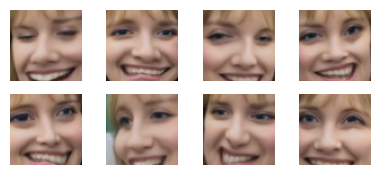

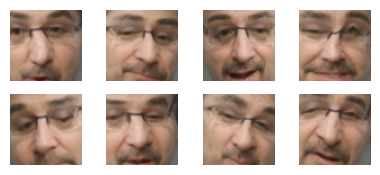

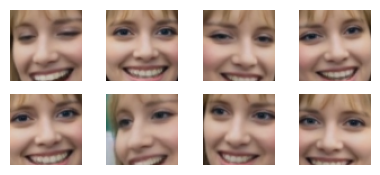

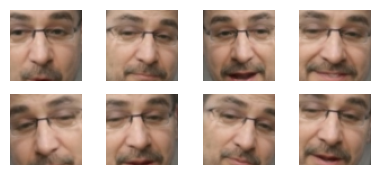

In [10]:
inspect(*next(iter(data_dl)))

for i in next(iter(data_dl)):
  subplots(i[:8],nc=4,sz=(4,2))

In [11]:
import torch
import torch.nn as nn

def _ConvLayer(input,output):
  return nn.Sequential(
      nn.Conv2d(input,output,kernel_size=5,stride=2,padding=2),
      nn.LeakyReLU(0.1,inplace=True)
  )

def _UpScale(input,output):
  return nn.Sequential(
      nn.ConvTranspose2d(input,output,kernel_size=2,stride=2,padding=0),
      nn.LeakyReLU(0.1,inplace=True)
  )


class Reshape(nn.Module):
  def forward(self,input):
    output = input.view(-1,1024,4,4)
    return output

class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        _ConvLayer(3,128),
        _ConvLayer(128,256),
        _ConvLayer(256,512),
        _ConvLayer(512,1024),
        nn.Flatten(),
        nn.Linear(1024*4*4,1024),
        nn.Linear(1024,1024*4*4),
        Reshape(),
        _UpScale(1024,512)
    )

    self.decoder_A = nn.Sequential(
        _UpScale(512,256),
        _UpScale(256,128),
        _UpScale(128,64),
        nn.Conv2d(64,3,kernel_size=3,padding=1),
        nn.Sigmoid()
    )
    self.decoder_B =nn.Sequential(
        _UpScale(512,256),
        _UpScale(256,128),
        _UpScale(128,64),
        nn.Conv2d(64,3,kernel_size=3,padding=1),
        nn.Sigmoid()
    )


  def forward(self,x,select="A"):
    if select =="A":
      out = self.encoder(x)
      out = self.decoder_A(out)
    else:
      out = self.encoder(x)
      out = self.decoder_B(out)

    return out

In [12]:
from torchsummary import summary
model = AutoEncoder().to(device)

summary(model,torch.zeros(32,3,64,64),"A")

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 8, 8]           --
|    └─Sequential: 2-1                   [-1, 128, 32, 32]         --
|    |    └─Conv2d: 3-1                  [-1, 128, 32, 32]         9,728
|    |    └─LeakyReLU: 3-2               [-1, 128, 32, 32]         --
|    └─Sequential: 2-2                   [-1, 256, 16, 16]         --
|    |    └─Conv2d: 3-3                  [-1, 256, 16, 16]         819,456
|    |    └─LeakyReLU: 3-4               [-1, 256, 16, 16]         --
|    └─Sequential: 2-3                   [-1, 512, 8, 8]           --
|    |    └─Conv2d: 3-5                  [-1, 512, 8, 8]           3,277,312
|    |    └─LeakyReLU: 3-6               [-1, 512, 8, 8]           --
|    └─Sequential: 2-4                   [-1, 1024, 4, 4]          --
|    |    └─Conv2d: 3-7                  [-1, 1024, 4, 4]          13,108,224
|    |    └─LeakyReLU: 3-8               [-1, 1024, 4, 4]     

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 8, 8]           --
|    └─Sequential: 2-1                   [-1, 128, 32, 32]         --
|    |    └─Conv2d: 3-1                  [-1, 128, 32, 32]         9,728
|    |    └─LeakyReLU: 3-2               [-1, 128, 32, 32]         --
|    └─Sequential: 2-2                   [-1, 256, 16, 16]         --
|    |    └─Conv2d: 3-3                  [-1, 256, 16, 16]         819,456
|    |    └─LeakyReLU: 3-4               [-1, 256, 16, 16]         --
|    └─Sequential: 2-3                   [-1, 512, 8, 8]           --
|    |    └─Conv2d: 3-5                  [-1, 512, 8, 8]           3,277,312
|    |    └─LeakyReLU: 3-6               [-1, 512, 8, 8]           --
|    └─Sequential: 2-4                   [-1, 1024, 4, 4]          --
|    |    └─Conv2d: 3-7                  [-1, 1024, 4, 4]          13,108,224
|    |    └─LeakyReLU: 3-8               [-1, 1024, 4, 4]     

In [19]:
def train_batch(model,data,optimizers,loss_fn):
  optA,optB = optimizers
  optA.zero_grad()
  optB.zero_grad()
  imgA,imgB,targetA,targetB = data
  _imgA,_imgB= model(imgA,"A"),model(imgB,"B")

  lossA = loss_fn(_imgA,targetA)
  lossB = loss_fn(_imgB,targetB)

  lossA.backward()
  lossB.backward()

  optA.step()
  optB.step()

  return lossA.item(),lossB.item()

In [20]:
model = AutoEncoder().to(device)
dataset = face_dataset(Glob('cropped_faces_personA'),Glob("cropped_faces_personB"))
data_loader = DataLoader(dataset,batch_size=32,collate_fn = dataset.collate_fn)

optimizers = optim.Adam([{'params':model.encoder.parameters()},{'params':model.decoder_A.parameters()}],
                        lr = 5e-5 , betas = (0.5,0.999)),\
            optim.Adam([{'params':model.encoder.parameters()},{'params':model.decoder_B.parameters()}],
                        lr = 5e-5 , betas = (0.5,0.999)),

loss_fn = nn.L1Loss()

In [21]:
n_epochs = 1000
log =  Report(n_epochs)
!mkdir checkpoint

for ex in range(n_epochs):
  N = len(data_loader)
  for bx, data in enumerate(data_loader):
    loss_A,loss_B = train_batch(model,data,optimizers,loss_fn)
    log.record(ex + (bx+1)/N,lossA=loss_A,LossB=loss_B,end = '\r')

  log.report_avgs(ex+1)

  if (ex+1)%100 == 0:
    state = {
        'state' : model.state_dict(),
        'epoch' : ex,
    }
    torch.save(state,'./checkpoint/autoencoder.pth')

  if (ex+1)%100 ==0:
    bs = 5
    a,b,A,B = data
    line('A to B')
    _a = model(a[:bs],"A")
    _b = model(a[:bs],"B")

    x = torch.cat([A[:bs],_a,_b])
    subplots(x,nc=bs,figsize=(bs*2,5))

    line('B to A')
    _a = model(b[:bs],"A")
    _b = model(b[:bs],"B")
    x = torch.cat([A[:bs],_a,_b])
    subplots(x,nc=bs,figsize=(bs*2,5))

log.plot_epochs()

EPOCH: 403.000  lossA: 0.036  LossB: 0.031  (457.68s - 678.00s remaining)
EPOCH: 403.250  lossA: 0.035  LossB: 0.031  (458.07s - 677.88s remaining)

KeyboardInterrupt: 

100%|██████████| 1101/1101 [00:00<00:00, 2353.76it/s]


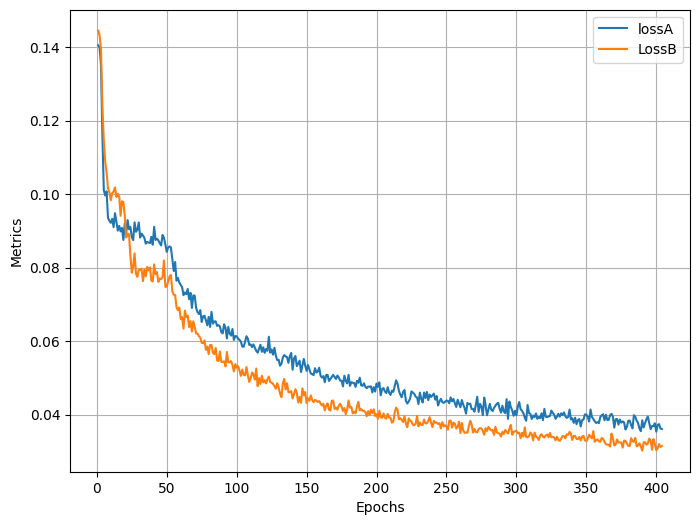

In [22]:
log.plot_epochs()